# Evolution of Learning

The model extends the model from [Xue & Leibler, PNAS 2016](http://www.pnas.org/lookup/doi/10.1073/pnas.1608756113).

At each generation:

1. individuals develop a phenotype according to their phenotype distribution $\pi$: $\pi_i \in [0,1]$ is the probability that a specific individual will develop to phenotype $\phi_i$.
1. the fitness of individuals is set according to their phenotype and the environment $\epsilon \in {0, 1}$.
. individuals reproduce: the relative contribution (fitness) of individuals with phenotype $\phi_i$ in environment $\epsilon_j$ to the next generation is $\frac{\omega_i^{(j)}}{\sum_k{\omega_k^j}}$.
1. each offspring phenotype distribution is inherited from its parent, where a fraction $1-\eta$ is determined according to the parent phenotype distribution and a fraction $\eta$ is determined according to the parent phenotype; the offspring distribution is $\pi_i' = (1-\eta)\phi_i + \eta \cdot \delta_{i,k}$, where $k$ is the parent phenotype.

See [Figure 1](http://www.pnas.org/content/113/40/11266/F1.expansion.html) from Xue 2016.

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(style='ticks', context='paper', font_scale=1.5)
red, blue, green, _, _, yellow, *_ = sns.color_palette('Set1', 9)
from simulation import *
from plots import *

# Figure 2

Here we reproduce Fig. 2 from Xue 2016.

The top row shows the averate $\pi$ in the population over time, the bottom row the effective population growth rate.

The different columns represent 3 environments, used throughout this document.
- Left panel - the environment is randomly chosen at each generation such that P(A)=0.7 and P(B)=0.3.
- Middle panel - the environment flips between A and B, the duration of each is geometrically distributed with p=1/10 for A and p=1/5 for B.
- Right panel - the environments flips every 40 generations.

The population is initialized such that $\pi \sim Normal(0.5, 0.05)$.

Parameters:

In [83]:
N=100000
n=100
η=0.1
μ=0
ω0=2
ω1=0.2
π0=0.5

Figure (compare with [Figure 2](http://www.pnas.org/content/113/40/11266/F5.expansion.html) from Xue 2016)

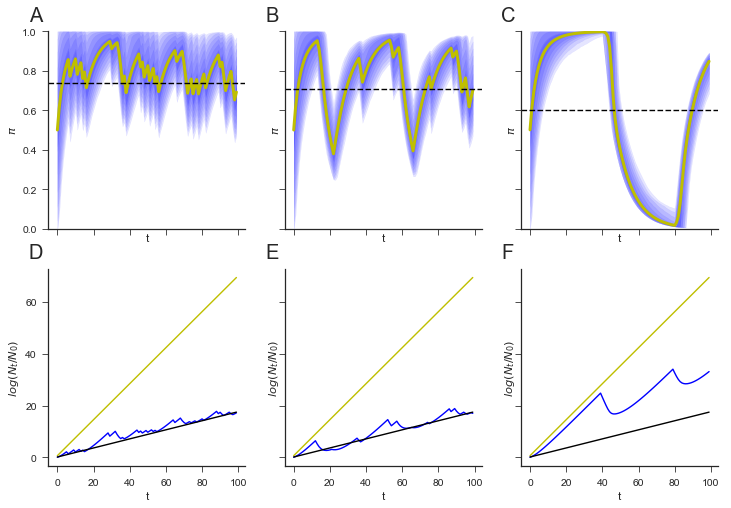

In [84]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey='row')

## Fig. 2A
ϵ = np.random.choice(2, n, True, [0.7, 0.3])
π = simulation(N, n, η, μ, ω0, ω1, π0, ϵ)
plot_π(π, ϵ, ax=ax[0, 0])
plot_logNtN0(π, ω0, ω1, 0.7, ϵ, ax=ax[1,0])

## Fig. 2B
ϵ, a = np.zeros(n, dtype=int), 0
while a < ϵ.size:
    a += np.random.geometric(1/10)
    g = np.random.geometric(1/5)
    ϵ[a: a + g] = 1
    a += g
π = simulation(N, n, η, μ, ω0, ω1, π0, ϵ)
plot_π(π, ϵ, ax=ax[0,1])
plot_logNtN0(π, ω0, ω1, 0.7, ϵ, ax=ax[1,1])

## Fig. 2C
ϵ = np.array([0] * 40 + [1] * 40 + [0] * 20)
π = simulation(N, n, η, μ, ω0, ω1, π0, ϵ)
plot_π(π, ϵ, ax=ax[0,2])
plot_logNtN0(π, ω0, ω1, 0.7, ϵ, ax=ax[1,2])

for ax_, label in zip(ax.flat, 'ABCDEFGHIJKLMNOP'):
    ax_.annotate(label, (-0.1, 1.05), xycoords='axes fraction', fontsize=20)

plt.savefig('figures/figure2_reproduction.pdf')

Original figure:    
<img src="http://www.pnas.org/content/113/40/11266/F5.large.jpg" alt="Figure 2" style="width: 700px; float: left"/>

# Modifier competitions in Fig. 2

We now extend the model:
1. We now have two learning modifeirs $\eta_1, \eta_2$, that can have different values.
1. We also have mutations in the modifier loci, with probability $\kappa$, which convert $\eta_i$ to $\eta_j$.

The following figure shows the dynamics of Fig. 2 with the modifiers $\eta_1=0.1, \eta_2=0, \kappa=0$.

In [86]:
N=100000
n=500
η1=0.1
η2=0
μ1=0
μ2=0
ω0=2
ω1=0.2
π0=0.5
κ = 0

ϵA = np.random.choice(2, n, True, [0.7, 0.3])
πA, η_barA, μ_barA = simulation_modifiers(N, n, η1, η2, μ1, μ2, ω0, ω1, π0, κ, ϵA)

ϵB, a = np.zeros(n, dtype=int), 0
while a < ϵ.size:
    a += np.random.geometric(1/10)
    g = np.random.geometric(1/5)
    ϵB[a: a + g] = 1
    a += g
πB, η_barB, μ_barB = simulation_modifiers(N, n, η1, η2, μ1, μ2, ω0, ω1, π0, κ, ϵB)

ϵC = np.array(([0] * 40 + [1] * 40) * (n//80 + 1))
πC, η_barC, μ_barC = simulation_modifiers(N, n, η1, η2, μ1, μ2, ω0, ω1, π0, κ, ϵC)

figures/modifiers_η1_0.1_η2_0_κ_0.pdf


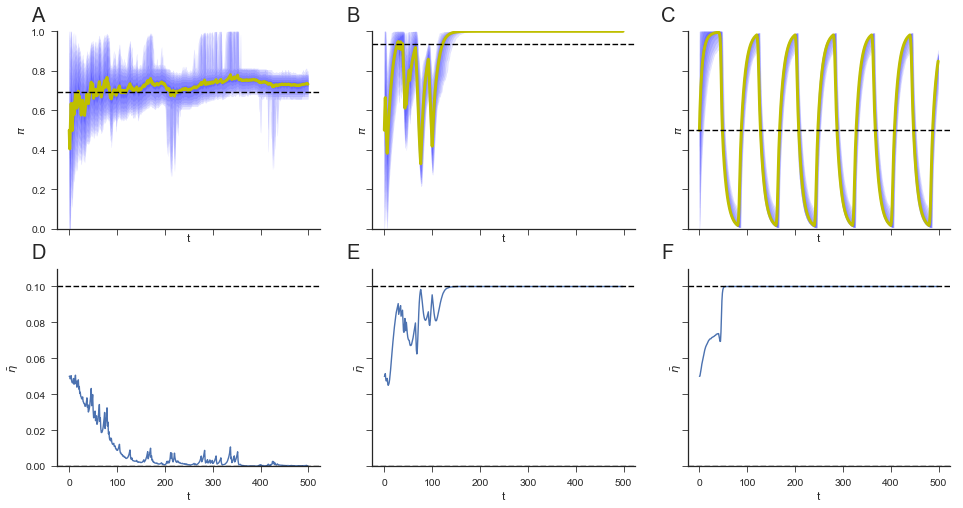

In [87]:
fig, ax = plt.subplots(2, 3, figsize=(16, 8), sharex=True, sharey='row')

plot_π(πA, ϵA, ax=ax[0, 0])
plot_η(η_barA, η1, η2, ax=ax[1, 0])

plot_π(πB, ϵB, ax=ax[0, 1])
plot_η(η_barB, η1, η2, ax=ax[1, 1])

plot_π(πC, ϵC, ax=ax[0, 2])
plot_η(η_barC, η1, η2, ax=ax[1, 2])

for ax_, label in zip(ax.flat, 'ABCDEFGHIJKLMNOP'):
    ax_.annotate(label, (-0.1, 1.05), xycoords='axes fraction', fontsize=20)


fname = 'figures/modifiers_η1_{:.2g}_η2_{:.2g}_κ_{:.2g}.pdf'.format(η1, η2, κ)
plt.savefig(fname)
print(fname)

And here with $\kappa=0.001$:

In [88]:
N=100000
n=500
η1=0.1
η2=0
μ1=0
μ2=0
ω0=2
ω1=0.2
π0=0.5
p0 = 0.5
κ = 0.001

ϵA = np.random.choice(2, n, True, [0.7, 0.3])
πA, η_barA, μ_barA = simulation_modifiers(N, n, η1, η2, μ1, μ2, ω0, ω1, π0, κ, ϵA)

ϵB, a = np.zeros(n, dtype=int), 0
while a < ϵ.size:
    a += np.random.geometric(1/10)
    g = np.random.geometric(1/5)
    ϵB[a: a + g] = 1
    a += g
πB, η_barB, μ_barB = simulation_modifiers(N, n, η1, η2, μ1, μ2, ω0, ω1, π0, κ, ϵB)

ϵC = np.array(([0] * 40 + [1] * 40) * (n//80 + 1))
πC, η_barC, μ_barC = simulation_modifiers(N, n, η1, η2, μ1, μ2, ω0, ω1, π0, κ, ϵC)

figures/modifiers_η1_0.1_η2_0_κ_0.001.pdf


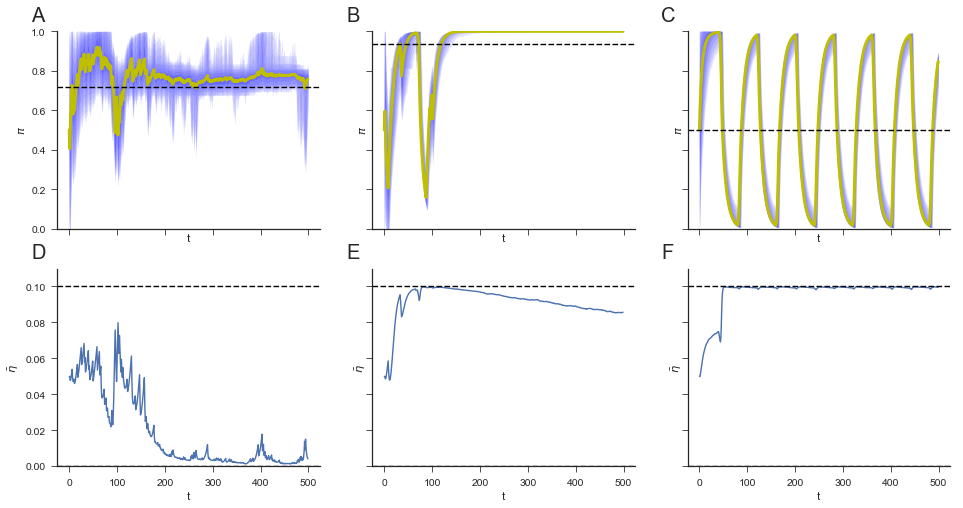

In [89]:
fig, ax = plt.subplots(2, 3, figsize=(16, 8), sharex=True, sharey='row')
plot_π(πA, ϵA, ax=ax[0, 0])
plot_η(η_barA, η1, η2, ax=ax[1, 0])

plot_π(πB, ϵB, ax=ax[0, 1])
plot_η(η_barB, η1, η2, ax=ax[1, 1])

plot_π(πC, ϵC, ax=ax[0, 2])
plot_η(η_barC, η1, η2, ax=ax[1, 2])

for ax_, label in zip(ax.flat, 'ABCDEFGHIJKLMNOP'):
    ax_.annotate(label, (-0.1, 1.05), xycoords='axes fraction', fontsize=20)

fname = 'figures/modifiers_η1_{:.2g}_η2_{:.2g}_κ_{:.2g}.pdf'.format(η1, η2, κ)
plt.savefig(fname)
print(fname)

## Multiple simulations

We now run multiple simulations like the above to perform some statistics on their results.

Simuations ran with:

```
python simulation.py --N 100000 --n 500 --η1 0.1 --η2 0.2 --ω0 2.0 --ω1 0.2  --π0 0.5  --env A
```
and results were saved to `output` folder.

In [90]:
import glob
import os
import json
import gzip

In [91]:
df1 = load_simulations('output1', True, False)
df1.shape

(1499000, 13)

KeyError: 'μ'

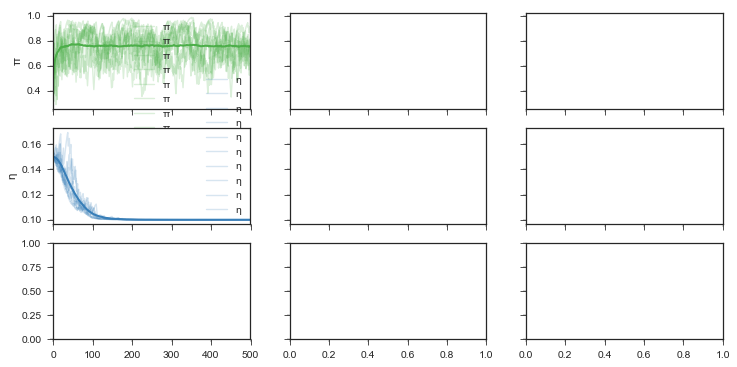

In [92]:
ax = plot_simulations(df1)
for ax_, label in zip(ax.flat, 'ABCDEFGHIJKLMNOP'):
    ax_.annotate(label, (-0.1, 1.05), xycoords='axes fraction', fontsize=20)
fname = 'figures/modifiers_η1_{}_η2_{}_κ_0.pdf'.format(
    *df1.η1.unique(), *df1.η2.unique())
plt.savefig(fname)
print(fname)

# Genetic vs Epigenetic modifiers

Compete genetic (mutation, $\mu$) vs epigenetic (learning; $\eta$) modifiers.

In [ ]:
df = load_simulations('output2', True, True)

In [ ]:
df.head()

In [ ]:
df.η2 = df.η2.astype(float)
df.η1.unique(), df.η2.unique(), df.μ1.unique(),df.μ2.unique()

In [ ]:
for η1 in df.η1.unique():
    _df = df[df.η1==η1]
    for η2 in _df.η2.unique():
        __df = _df[_df.η2==η2]
        for μ1 in __df.μ1.unique():
            ___df = __df[__df.μ1==μ1]
            for μ2 in ___df.μ2.unique():
                ____df = ___df[___df.μ2==μ2]
                print("η1={}, η2={}, μ1={}, μ2={}, len={}".format(η1, η2, μ1, μ2, ____df.shape[0]))

## η=0.1 μ=0.0   vs.   η=0.0 μ=0.1

In [ ]:
_df = df[(df.η1==0.1) & (df.η2==0) & (df.μ1==0) & (df.μ2==0.1)]
_df.shape

In [ ]:
plot_simulations(_df);

Competing learners vs mutators we see that the frequency of both modifiers decreases in the left panel and increases in the middle and right panel; this is depsite the fact that initially the modifiers are unlinked, because mutation at the modifier loci allows them the optimal genotype to be created, and therefore in the middle and right panel the blue and red curves start negatively correlated and later become positively correlated.

## η=0.0 μ=0.0 vs. η=0.1 μ=0.1

In [ ]:
_df = df[(df.η1==0) & (df.η2==0.1) & (df.μ1==0) & (df.μ2==0.1)]
_df.shape

In [ ]:
plot_simulations(_df);

Competing genotypes with both a learner and a mutator vs genotypes without either, we see a similar end result to the above.

## η=0.99 μ=0.0 vs. η=0.0 μ=0.01

In [ ]:
_df = df[(df.η1==0.99) & (df.η2==0) & (df.μ1==0) & (df.μ2==0.01)]
_df.shape

In [ ]:
ax = plot_simulations(_df)
ax[2,0].set_ylim(0, 0.0105)

Competing a strong learner (0.99) vs a weak mutator (0.01) we see that the weak mutato fixes in all environments, whereas the strong learner doesn't fix in the left panel (as before). 

# Diversity

We now look a the diversity of the population, in terms of $\pi$ values, when evolving in slowly changing environments (left panels in the above figures).

For tracktability, the population now starts fixed at $\pi=0.5$ and then evolves.

In [ ]:
def isogenic(N):
    x = np.ones(N) * 0.5
    return x

In [ ]:
ε = np.array([0]*50+[1]*50+[0]*50+[1]*50+[0]*50+[1]*50+[0]*50+[1]*50)
π = simulation(10000, 400, 0.1, 0, 2.0, 0.2, 0.5, ε)

In [ ]:
plot_π(π, ε);

We've seen this before - the dynamics of the average $\pi$ in the population over time.

In [ ]:
def shannon(x):
    """Calculates Shannon Index: -sum_k{log(p_k) p_k} where k are value in input array x and p_k are frequencies of k in x.
    
    Parameters
    ----------
    x : np.ndarray
        array of values
        
    Returns
    -------
    float
        the shannon index
    """
    freqs = (np.unique(x).reshape(-1, 1) == x).mean(axis=1)
    nonzero_freqs = freqs[freqs.nonzero()]
    return -(nonzero_freqs * np.log(nonzero_freqs)).sum()

In [ ]:
shannon_idx = [shannon(π[t,:]) for t in range(π.shape[0])]

In [ ]:
fig, ax = plt.subplots(3, 1, sharex=True, sharey=False)
ax[0].plot(range(0, π.shape[0]), [len(np.unique(π[i,:])) for i in range(0, π.shape[0])])
ax[0].set(xlabel=('t'), ylabel=('richness'))
ax[1].plot(range(0, π.shape[0]), np.exp(shannon_idx))
ax[1].set(xlabel=('t'), ylabel=('true diversity'))
plot_π(π, ε, ax=ax[2])
ax[0].set_ylim(0, 1200)
ax[1].set_ylim(0, 400)
sns.despine()

for ax_, label in zip(ax.flat, 'ABCDEFGHIJKLMNOP'):
    ax_.annotate(label, (-0.1, 1.05), xycoords='axes fraction', fontsize=20)
plt.savefig('figures/diversity_envA.pdf')

This plot shows the richness (# of different value; top), true diversity (exponent of Shannon index; middle) and average (bottom) of $\pi$ in the population.

In [ ]:
fig, axes = plt.subplots(1, 5, sharex=True, sharey=True, figsize=(10, 4)) 
bins = 50
for ax, t in zip(axes, [100,105,110,115,120]):
    ax.hist(π[t, :], bins=bins, color='k', normed=True, cumulative=False)
    ax.set(xlabel='', title='t = {}'.format(t))
axes[0].set(ylabel='Frequency', yscale='log')
axes[2].set(xlabel='π')
fig.tight_layout()
sns.despine()
plt.savefig('figures/π_distribution_in_env_change.pdf')

This figure shows the distribution of $\pi$ in the population during one environmental change.

## Periodic environment /w period 1, uniform initial density, non-extreme selection, with learning

Compare with a random environment with same empirical distribution:

In [6]:
N=10000
n=1000
η=0.01
μ=0
ω0=1
ω1=0.9

ϵ1 = np.zeros(n, dtype=int)
ϵ1[::2] = 1
π0 = lambda N: np.random.random(N)
π1 = simulation(N, n, η, μ, ω0, ω1, π0, ϵ1)

ϵ2 = np.zeros(n, dtype=int)
ϵ2[::3] = 1
π0 = lambda N: np.random.random(N)
π2 = simulation(N, n, η, μ, ω0, ω1, π0, ϵ2)

ϵ3 = np.random.randint(0, 2, n, dtype=int)
π0 = lambda N: np.random.random(N)
π3 = simulation(N, n, η, μ, ω0, ω1, π0, ϵ3)

ϵ4 = np.random.randint(0, 3, n, dtype=int)
ϵ4[ϵ4==2] = 0
π0 = lambda N: np.random.random(N)
π4 = simulation(N, n, η, μ, ω0, ω1, π0, ϵ4)

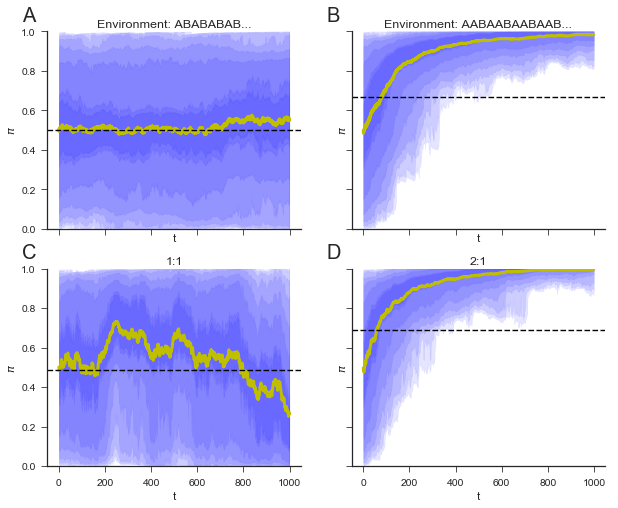

In [7]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10,8))
plot_π(π1, ϵ1, ax=ax[0,0]);
ax[0,0].set_title('Environment: ABABABAB...')
plot_π(π2, ϵ2, ax=ax[0,1]);
ax[0,1].set_title('Environment: AABAABAABAAB...')
plot_π(π3, ϵ3, ax=ax[1,0]);
ax[1,0].set_title('1:1')
plot_π(π4, ϵ4, ax=ax[1,1])
ax[1,1].set_title('2:1')

for ax_, label in zip(ax.flat, 'ABCDEFGHIJKLMNOP'):
    ax_.annotate(label, (-0.1, 1.05), xycoords='axes fraction', fontsize=20)
sns.despine()
plt.savefig('figures/periodic_environment.pdf')

The solution in _ABABAB_ environment is:
$$
\frac{1}{2 η ωA - 2 η ωB - 4 ωA + 4 ωB} \left(η ωA - η ωB - ωA + 3 ωB - \sqrt{η^{2} ωA^{2} - 2 η^{2} ωA ωB + η^{2} ωB^{2} - 2 η ωA^{2} + 4 η ωA ωB - 2 η ωB^{2} + ωA^{2} + 2 ωA ωB + ωB^{2}}\right)
$$

In [20]:
def sol(η, ωA, ωB):
    return (η*ωA - η*ωB - ωA + 3*ωB - np.sqrt(η**2*ωA**2 - 2*η**2*ωA*ωB + η**2*ωB**2 - 2*η*ωA**2 + 4*η*ωA*ωB - 2*η*ωB**2 + ωA**2 + 2*ωA*ωB + ωB**2))/(2*η*ωA - 2*η*ωB - 4*ωA + 4*ωB)

In [53]:
Ns=[1000, 100000]
n=1000
η=0.1
μ=0
ω0s=[1, 10]
ω1=0.1

ϵ = np.zeros(n, dtype=int)
ϵ[::2] = 1
π0 = lambda N: np.ones(N)*0.5
π = [[simulation(N, n, η, μ, ω0, ω1, π0, ϵ) for ω0 in ω0s] for N in Ns]
πhat = [[sol(η, ω1, ω0) for ω0 in ω0s] for N in Ns]

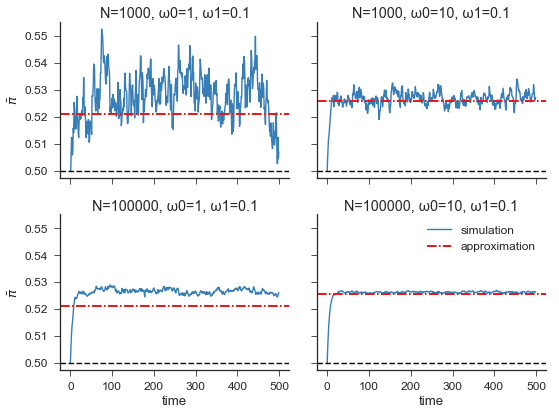

In [55]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(8, 6))
for i in range(2):
    for j in range(2):
        N = Ns[i]
        ω0 = ω0s[j]
        ax = axes[i,j]
        ax.plot(π[i][j].mean(axis=1)[::2], color=blue, label='simulation')
        ax.axhline(πhat[i][j], color=red, ls='-.', lw=2, label='approximation')
        ax.axhline(0.5, color='k', ls='--')
        ax.set(
            title="N={}, ω0={}, ω1={}".format(N, ω0, ω1)
        )
for i in range(2):
    axes[i,0].set_ylabel(r'$\bar{\pi}$')
for i in range(2):
    axes[1,i].set_xlabel('time')
ax.legend(loc='upper right')
fig.tight_layout()
sns.despine()